In [15]:
from uncertainties import ufloat, umath
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt
from scipy.odr import ODR,Model,RealData
import sys

In [16]:
#paar Unsicherheitsfunktionen
def rechteck(x): #Unsicherheit bei Rechtecksverteilung oder bei zwei Dreiecksverteilungen
    return x/(2*np.sqrt(3))

def dreieck(x): #Unsicherheit bei Dreiecksverteilung
    return x/(2*np.sqrt(6))

def kombUnsicherheit(x,u_mess_rel,offset_u_mess,u_ablese): #Kombination aus Unsicherheit des Messgerätes und Ableseunsicherheit
    u_mess=(x+offset_u_mess)*u_mess_rel
    return np.sqrt(u_mess**2+u_ablese**2)

def rel_abweichung(messwert,theoriewert):
  return (messwert-theoriewert)/theoriewert

def rel_unsicherheit(x):
  return x.s/x.n

def mittelwert(uarray):
  t_factor=np.array([1.84,1.32,1.2,1.14,1.11,1.09,1.08,1.07,1.06,1.05])
  length=uarray.size
  mean=uarray.mean()
  if (length<=10):
    mean=ufloat(mean.n,mean.s*t_factor[length-1])
  return mean

def uprint(ufloat):
  print('{:.2uS}'.format(ufloat))

def uarray_print(uarray):
  for ufloat in uarray:
    uprint(ufloat)

# 1. Bestimmung von κ nach Rüchardt-Flammersfeld
### (b) für 6 Abstände der Schellen die Zeit von 100 Schwingungen messen für Argon, Luft und CO2
Messwerte

In [22]:
u_messstock = dreieck(2e-3)
u_messzange = dreieck(1e-4)
u_waage = rechteck(1e-4)

luftdruck = ufloat(100670,100670*0.01) #1% rel Unsicherheit
durchmesser_rohr=ufloat(0.016,u_messstock)
masse_schwingkoerper = ufloat(7.2e-3,u_waage)
hoehe_schlitz = ufloat(0.111,u_messstock)
volumen_flasche = ufloat(5.45e-3,5.45e-3*0.01) #5% rel. Unsicherheit
volumen_gesamt = volumen_flasche+np.pi*(durchmesser_rohr/2)**2*hoehe_schlitz

u_t_messung = dreieck(0.25)**2 #Dreiecksverteilung um circa halbe Periode
u_t_ablese = dreieck(0.2) #wegen svideomethode nachkommastellen oft kaum bis gar nicht erkennbar
u_t = np.sqrt(u_t_messung**2+u_t_ablese**2)

breiten_schlitz = unp.uarray([0.5e-3,1e-3,1.5e-3,2e-3,2.5e-3,3e-3],u_messzange)

t_100schwingungen_luft = unp.uarray([54.47,53.59,54.04,53.7,54.01,54.3],u_t)
T_luft = t_100schwingungen_luft/100

t_100schwingungen_argon = unp.uarray([50.02,49.9,52.17,50.73,51.03,51.5],u_t)
T_argon = t_100schwingungen_argon/100

#bei co2 zählt die ableseunsicherheit nicht mit rein, da hiernicht die videomessmethode, sonder per hand gemessen wurde. 
#Die ableseunsicherheit der stoppuhr und die Unsicherheit des Gerätes sind gegenüber der Ungenauigkeit des Experimentators vernachlässigbar
t_100schwingungen_co2 = unp.uarray([55.78,55.75,55.75,55.6,55.85,55.38],u_t_messung)
T_co2 = t_100schwingungen_co2/100 



### (d) Diagramm "Schwingungsdauer in Abhängigkeit vom Schellenabstand" anfertigen, κ aus y-Achsenabschnitt bestimmen

In [26]:
#ODR Fit
def konstante(beta,x):
  #beta[0] ist die Konstante
  return beta[0] + 0*x

model_konstante=Model(konstante)

#ODR-Fit luft
data_luft=RealData(unp.nominal_values(breiten_schlitz),
                  unp.nominal_values(T_luft),
                  sx=unp.std_devs(breiten_schlitz),
                  sy=unp.std_devs(T_luft))
data_luft
odr_luft= ODR(data_luft, model_konstante,[0.5])
odr_luft.set_job(fit_type=0)
output_luft=odr_luft.run()
output_luft.pprint()
beta_luft = output_luft.beta
beta_luft_err=output_luft.sd_beta


T_0_luft= ufloat(beta_luft[0],beta_luft_err[0])
uprint(T_0_luft)


Beta: [0.54018333]
Beta Std Error: [0.00137681]
Beta Covariance: [[2.78908058e-08]]
Residual Variance: 67.96544788458257
Inverse Condition #: 1.0
Reason(s) for Halting:
  Both sum of squares and parameter convergence
0.5402(14)


In [27]:
#ODR-Fit argon
data_argon=RealData(unp.nominal_values(breiten_schlitz),
                     unp.nominal_values(T_argon),
                     sx=unp.std_devs(breiten_schlitz),
                     sy=unp.std_devs(T_argon))
odr_argon= ODR(data_argon, model_konstante,[ 0.5])
odr_argon.set_job(fit_type=0)
output_argon=odr_argon.run()
output_argon.pprint()
beta_argon = output_argon.beta
beta_argon_err=output_argon.sd_beta


T_0_argon= ufloat(beta_argon[0],beta_argon_err[0])
uprint(T_0_argon)

Beta: [0.50891667]
Beta Std Error: [0.0035556]
Beta Covariance: [[2.78908058e-08]]
Residual Variance: 453.2776086886064
Inverse Condition #: 1.0
Reason(s) for Halting:
  Both sum of squares and parameter convergence
0.5089(36)


In [28]:
#ODR-Fit co2
data_co2=RealData(unp.nominal_values(breiten_schlitz),
                     unp.nominal_values(T_co2),
                     sx=unp.std_devs(breiten_schlitz),
                     sy=unp.std_devs(T_co2))
odr_co2= ODR(data_co2, model_konstante,[ 0.5])
odr_co2.set_job(fit_type=0)
output_co2=odr_co2.run()
output_co2.pprint()
beta_co2 = output_co2.beta
beta_co2_err=output_co2.sd_beta


T_0_co2= ufloat(beta_co2[0],beta_co2_err[0])
uprint(T_0_co2)

Beta: [0.55685]
Beta Std Error: [0.0006951]
Beta Covariance: [[1.13028067e-10]]
Residual Variance: 4274.749439999819
Inverse Condition #: 1.0
Reason(s) for Halting:
  Both sum of squares and parameter convergence
0.55685(70)


Plot

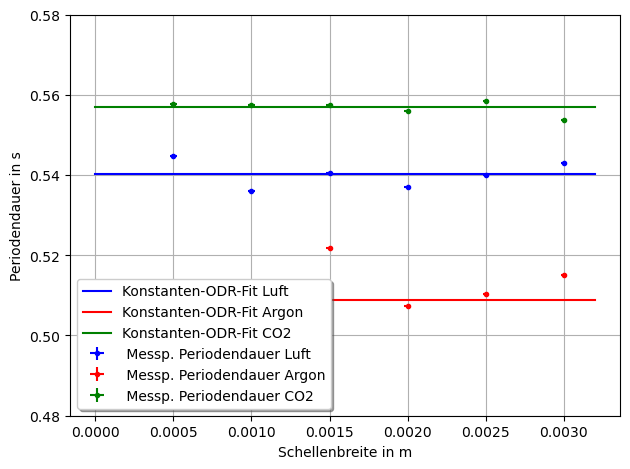

In [35]:
plt.figure()
x_int=np.linspace(0,3.2e-3)

plt.errorbar(unp.nominal_values(breiten_schlitz),unp.nominal_values(T_luft),
             xerr =unp.std_devs(breiten_schlitz),yerr=unp.std_devs(T_luft),
             linestyle="",marker=".", color="blue", label = " Messp. Periodendauer Luft")
plt.plot(x_int,konstante(beta_luft,x_int),
        color="blue",label="Konstanten-ODR-Fit Luft")

plt.errorbar(unp.nominal_values(breiten_schlitz),unp.nominal_values(T_argon),
             xerr =unp.std_devs(breiten_schlitz),yerr=unp.std_devs(T_argon),
             linestyle="",marker=".", color="red", label = " Messp. Periodendauer Argon")
plt.plot(x_int,konstante(beta_argon,x_int),
        color="red",label="Konstanten-ODR-Fit Argon")

plt.errorbar(unp.nominal_values(breiten_schlitz),unp.nominal_values(T_co2),
             xerr =unp.std_devs(breiten_schlitz),yerr=unp.std_devs(T_co2),
             linestyle="",marker=".", color="green", label = " Messp. Periodendauer CO2")
plt.plot(x_int,konstante(beta_co2,x_int),
        color="green",label="Konstanten-ODR-Fit CO2")

plt.ylim(0.48,0.58)
plt.grid()
plt.xlabel("Schellenbreite in m") 
plt.ylabel("Periodendauer in s")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig("plot_T_richardt_flammersfeld.pdf")

In [ ]:
#adiabatenexponent bestimmen


# 2. Bestimmung von κ nach Clément-Desormes
### Versuch 5 mal durchführen, κ bestimmen

In [38]:
u_barometer = dreieck(2e-3)

h_1 = unp.uarray([0.61,0.624,0.59,0.628,0.697,0.712],u_barometer)
h_3 = unp.uarray([0.176,0.14,0.141,0.16,0.146,0.157],u_barometer)

adiabaten_exponent_clement_alle = h_1/(h_1-h_3)
uarray_print(adiabaten_exponent_clement_alle)

adiabaten_exponent_clement_durchschnitt = adiabaten_exponent_clement_alle.mean()
print("Durchschnitts Adiabatenexponent:")
uprint(adiabaten_exponent_clement_durchschnitt)

1.4055(14)
1.2893(11)
1.3140(12)
1.3419(12)
1.26497(96)
1.28288(97)
Durchschnitts Adiabatenexponent:
1.31643(47)


# 3. Ergebnisse mit der Theorie der Freiheitsgrade vergleichen und diskutieren

# Zusammenfassung der Ergebnisse